Make sure your runtime is one of the gpus.
You can go to Runtime -> Change Runtime Type -> Choose "A100 GPU," "L4 GPU," or "T4 GPU"

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

using_colab = True

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.5.0+cu121
Torchvision version: 0.20.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ciz6dtkn
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ciz6dtkn
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=37ad490474d457e9a2482e45bb25162da8278b1cd8d9087eabc141aee7f8b47e
  Stored in directory: /tmp/pip-ephem-wheel-cache-xm3b95bb/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-11-05 15:51:54--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 18

Upload your images to the "images" folder on the left sidebar

#Getting the Scale Factor

We will get the scale to get a scale factor from pixels to nanometers. This will be used for our later calculatons. We only need to do this once for one image.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


def create_circular_mask(img_shape, center, radius):
  """Creates a circular mask."""
  Y, X = np.ogrid[:img_shape[0], :img_shape[1]]
  dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
  mask = dist_from_center <= radius
  return mask

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

predictor = SamPredictor(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Change image_file_path to the file path of an image with the scale (you only need one). You can replace "file_name_here" with the name of the file.

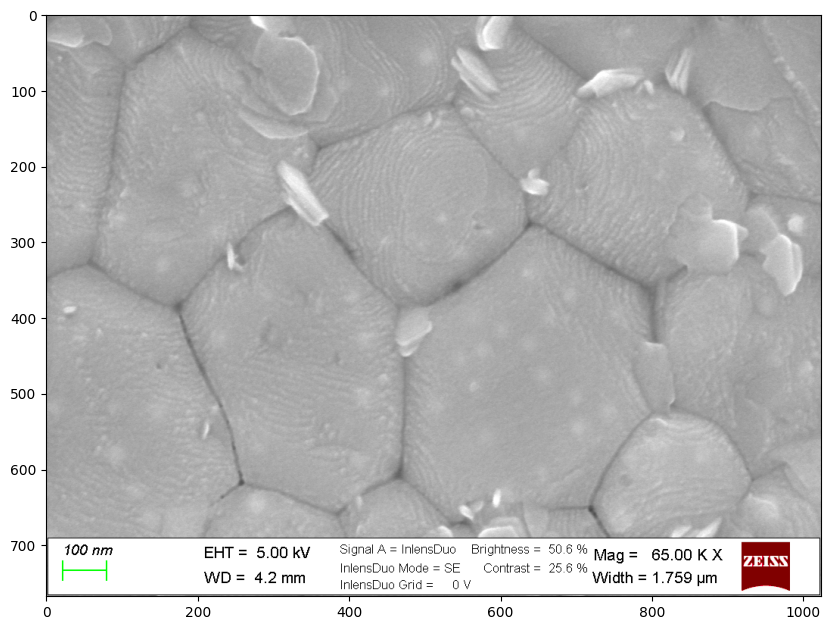

In [ ]:
image_file_path = "images/LHS04_08.tif" #@param {type:"string"}

image = cv2.imread(image_file_path)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

Change image_width_micrometers to whatever it is in the bottom right of the photo as the width.

In [ ]:
# Define the physical width of the image in micrometers
image_width_in_micrometers = 1.759  # @param {type:"number"}

# Width of the image in pixels
image_width_in_pixels = image.shape[1]

# Convert the image width from micrometers to nanometers
image_width_in_nanometers = image_width_in_micrometers * 1000

square_micrometers_to_square_nanometers = 10**6

# Calculate pixels to nanometers conversion factor
pixels_to_nanometers = image_width_in_nanometers / image_width_in_pixels

# Calculate pixels to micrometers conversion factor
pixels_to_micrometers = image_width_in_micrometers / image_width_in_pixels

print(f"Pixels to nanometers conversion factor: {pixels_to_nanometers} nm/pixel")
print(f"Pixels to micrometers conversion factor: {pixels_to_micrometers} μm/pixel")

Pixels to nanometers conversion factor: 1.7177734375 nm/pixel
Pixels to micrometers conversion factor: 0.0017177734375 μm/pixel


# Cropping the Images

We will adjust the parameters to properly crop the image. Now that we have the scale factor, we no longer need the bottom part of the images, so we will crop this out.

Change these variables: \
**x** is the x-coordinate of the top-left corner \
**y** is the y-coordinate of the top_left corner \
**w** is the width of the cropped area \
**h** is he height of the cropped area \

Run the cell and edit variables until the image is properly cropped.


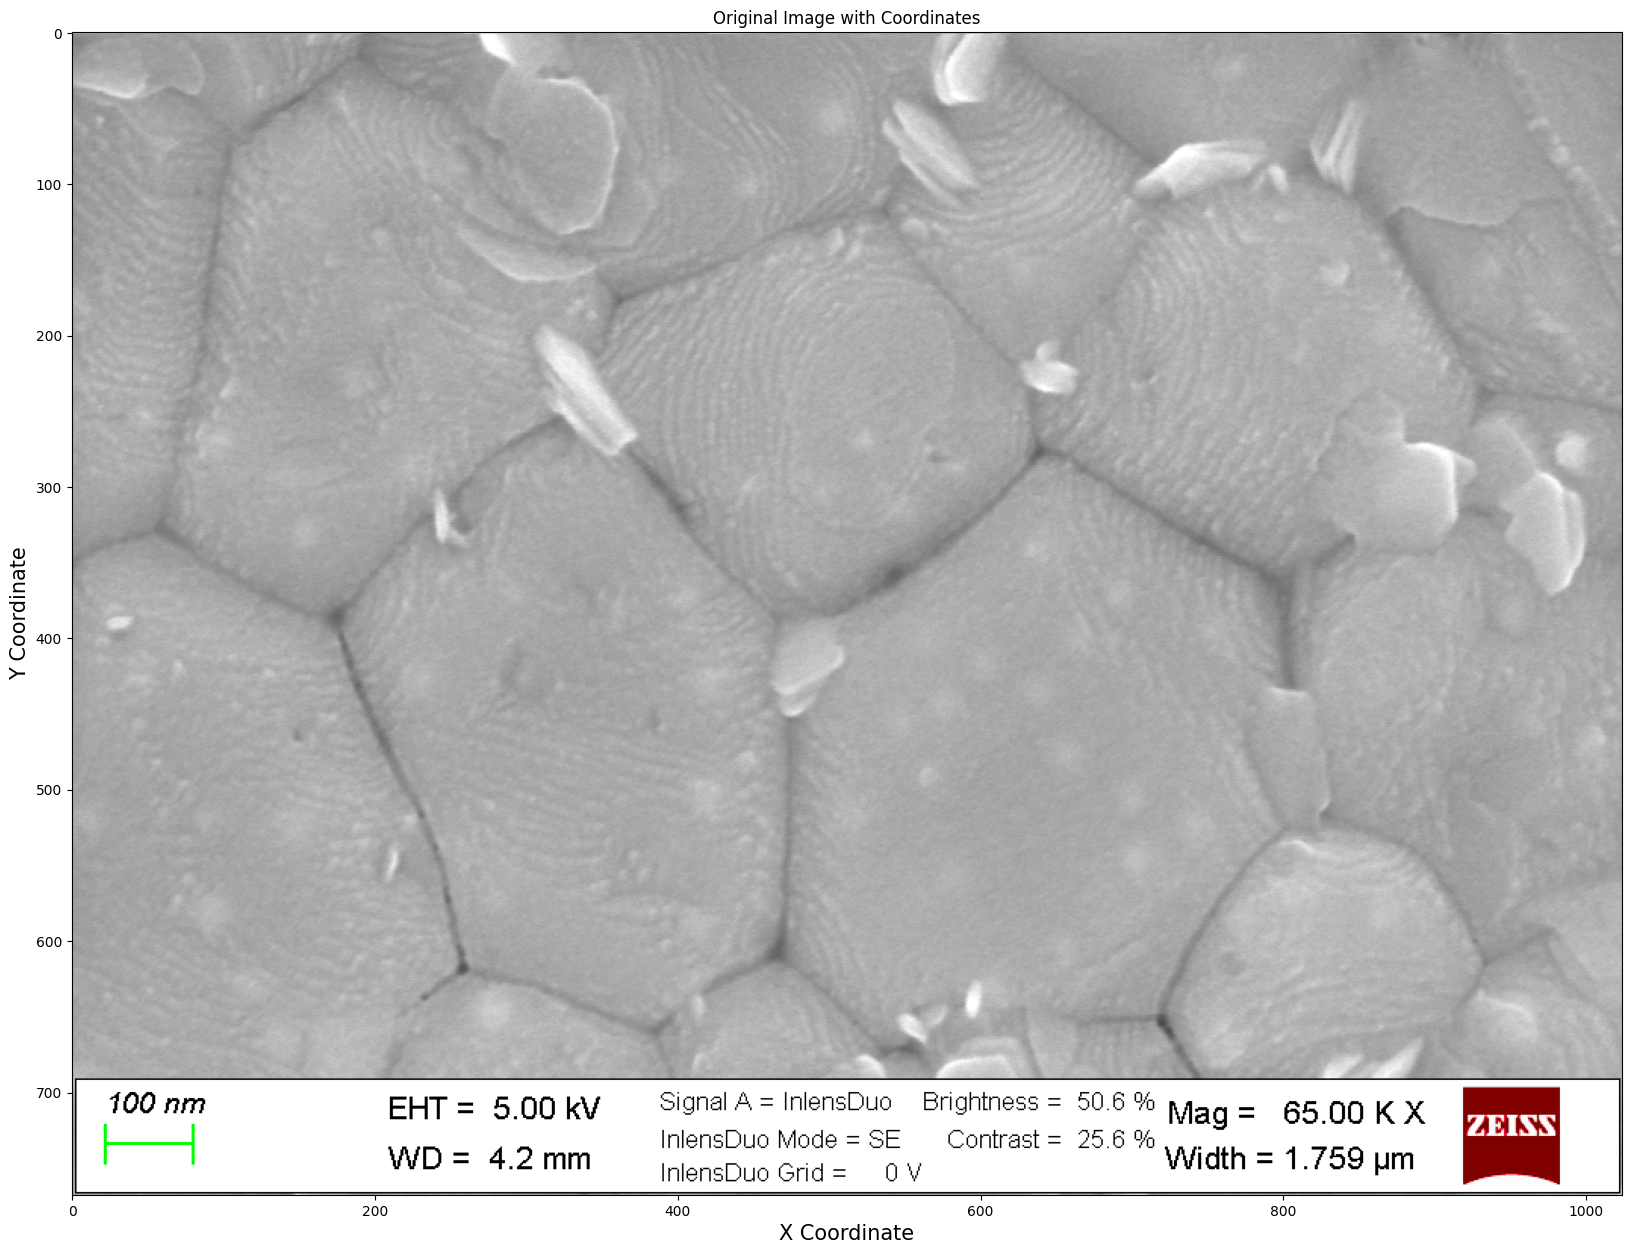

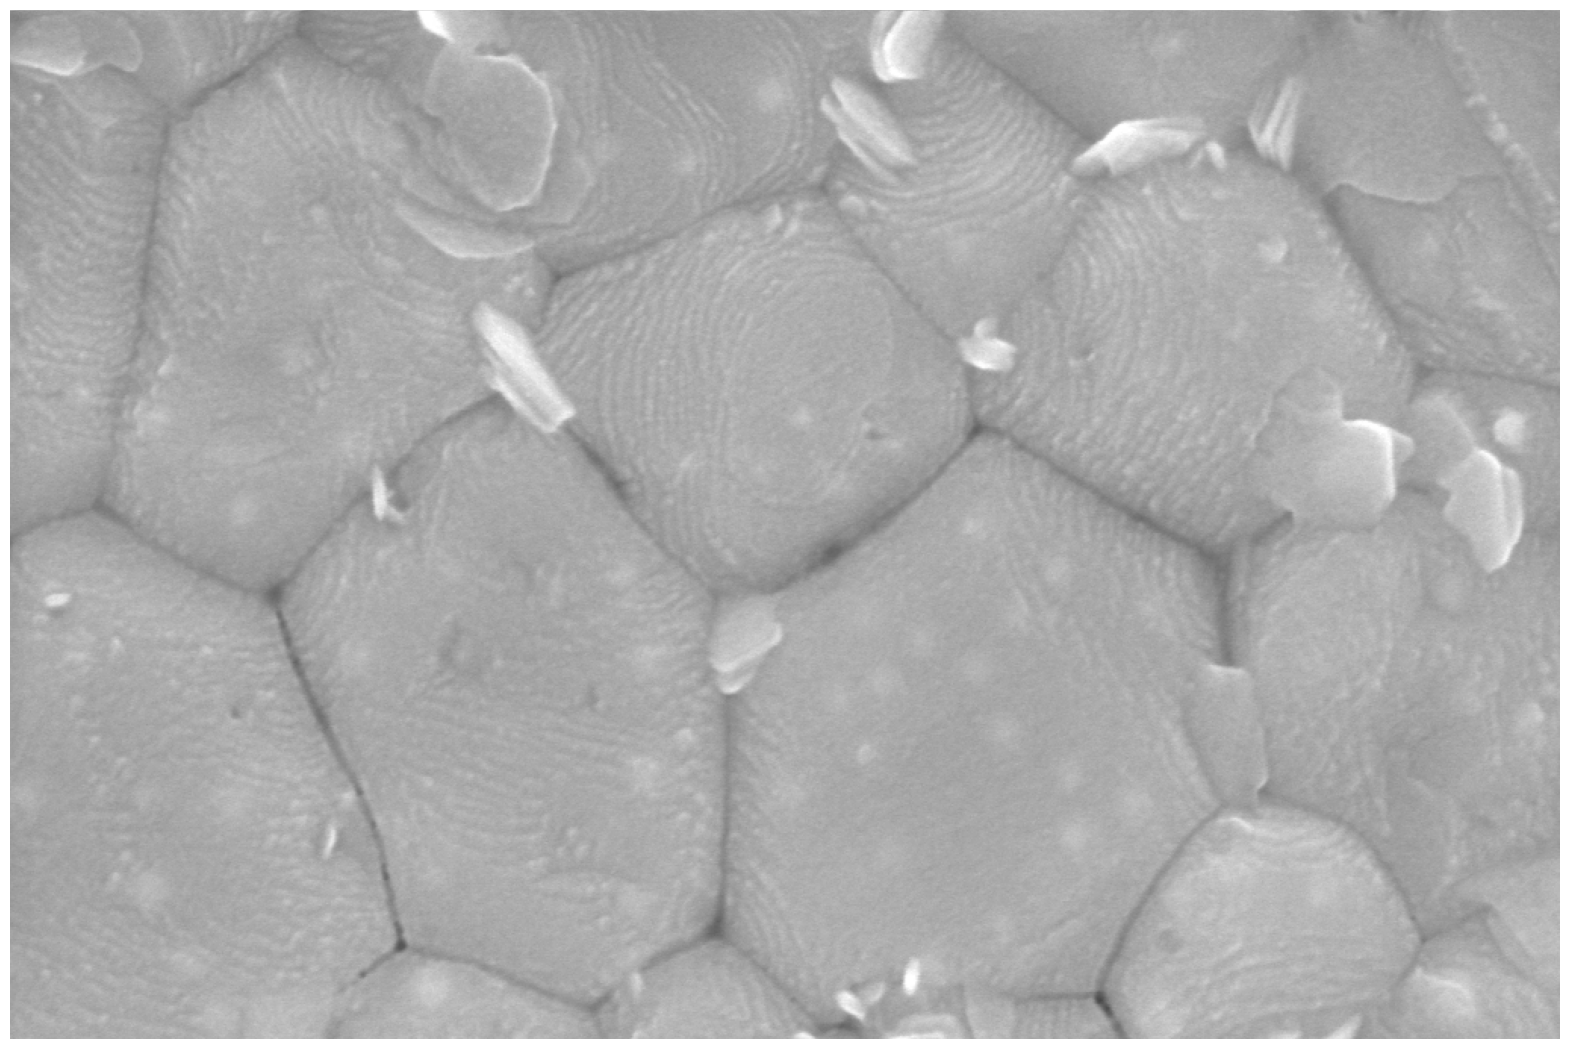

In [ ]:
# Define the coordinates and dimensions for cropping
# x-coordinate of the top-left corner
x = 0  #@param {type:"number"}

# y-coordinate of the top-left corner
y = 0 #@param {type:"number"}

# width of the cropped area
w = 1100 #@param {type:"number"}

# height of the cropped area
h = 680 #@param {type:"number"}

# Crop the image
crop_img = image[y:y+h, x:x+w]

# Display the original image with coordinates
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.title("Original Image with Coordinates")
plt.axis('on')  # Show the axes to display coordinates
plt.xlabel("X Coordinate", fontsize=15)
plt.ylabel("Y Coordinate", fontsize=15)
plt.show()

# Display the cropped image
plt.figure(figsize=(20, 20))
plt.imshow(crop_img)
#plt.title("Cropped Image")
plt.axis('off')  # Hide the axes for the cropped image
plt.show()

Now we are going to crop all of the images. Just run this cell. The same parameters will be used for all images.

In [ ]:
import os
import cv2

# Loop through files in the 'images' directory
for filename in os.listdir('images'):
    # Check if the file is a regular file and not a directory or a symbolic link
    if os.path.isfile(os.path.join('images', filename)):
        # Load the image
        image_path = os.path.join('images', filename)
        image = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if image is not None:
            # Convert to RGB if necessary
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Crop the image (define y, x, h, w as needed)
            crop_img = image[y:y+h, x:x+w]

            # Create the new filename with '_cropped' appended before the file extension
            base_name, ext = os.path.splitext(filename)
            new_filename = f"{base_name}_cropped{ext}"
            new_image_path = os.path.join('images', new_filename)

            # Save the cropped image
            cv2.imwrite(new_image_path, cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR))

            print(f"Cropped and saved: {new_filename}")
        else:
            print(f"Failed to load image: {filename}")

Cropped and saved: LHS04_08_cropped.tif
Cropped and saved: LHS04_15_cropped.tif
Cropped and saved: LHS04_14_cropped.tif


The model makes mistakes, and some masks will be either too small or too large. To remedy this we will remove all masks below lower_limit or above upper_limit, which you can set accordingly. These variables are in nanometers.

In [ ]:
lower_limit = 15000 #@param {type:"number"}
upper_limit = 500000 #@param {type:"number"}

# Running everything

Now that we have our scale factor, cropped images, and have all our parameters, we can now run everything smoothly.

Processing LHS04_14_cropped.tif...


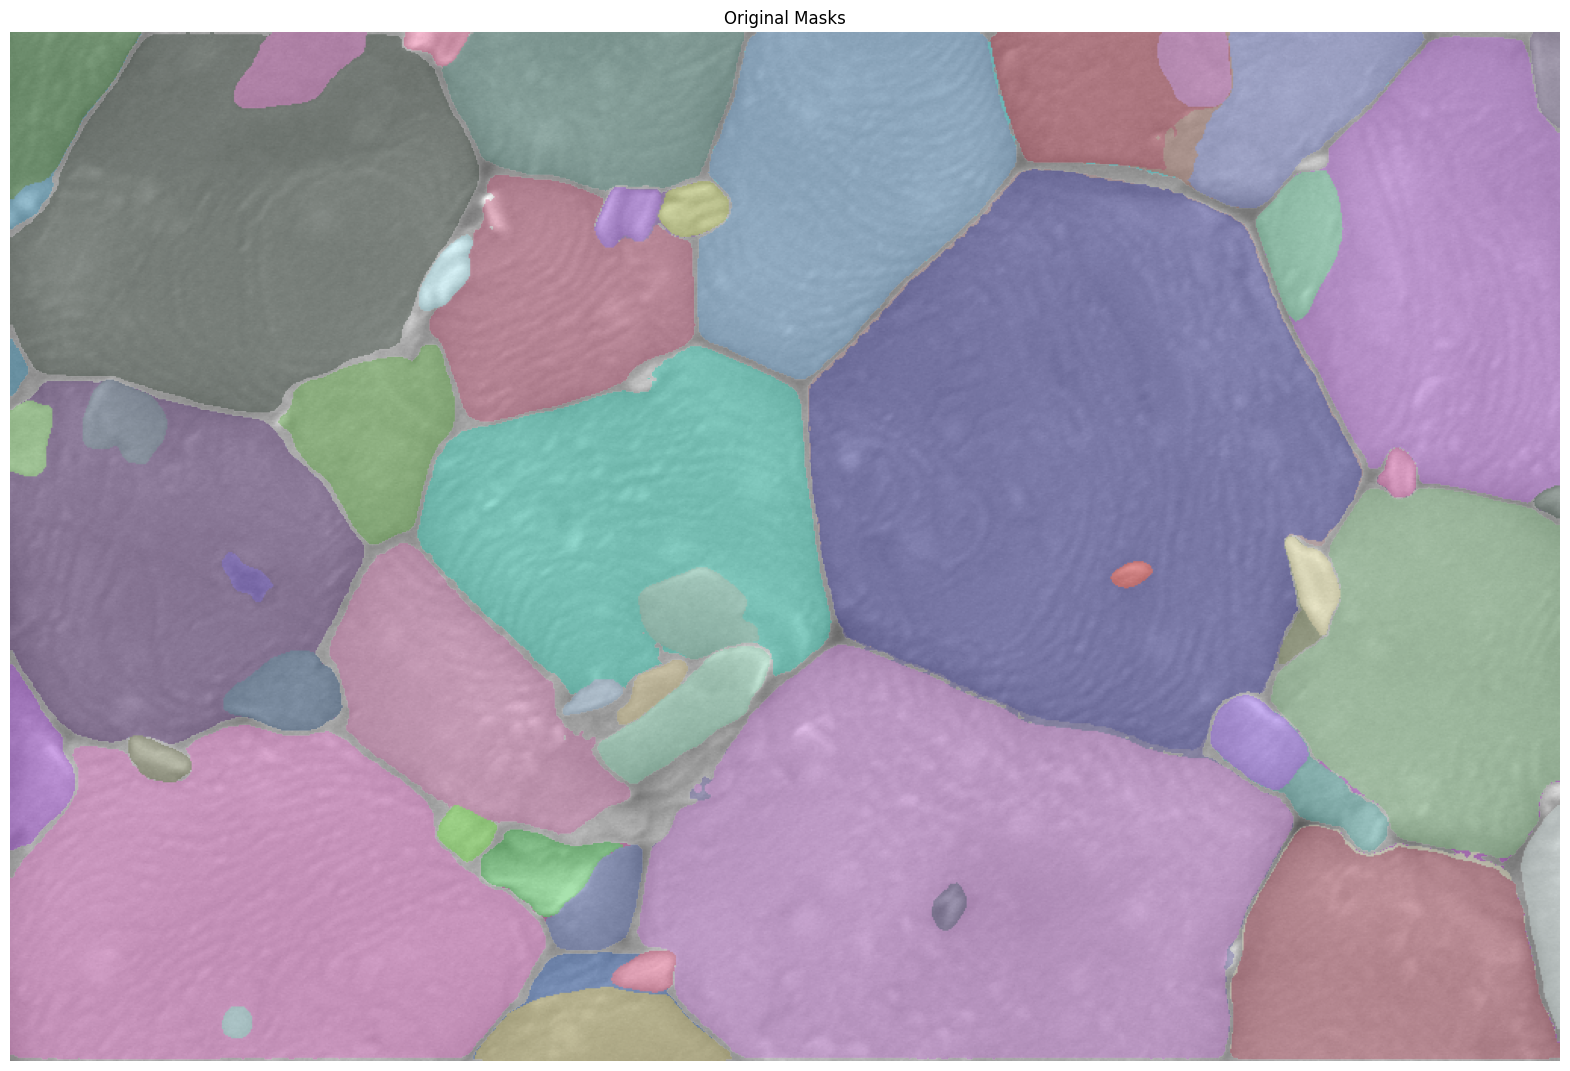

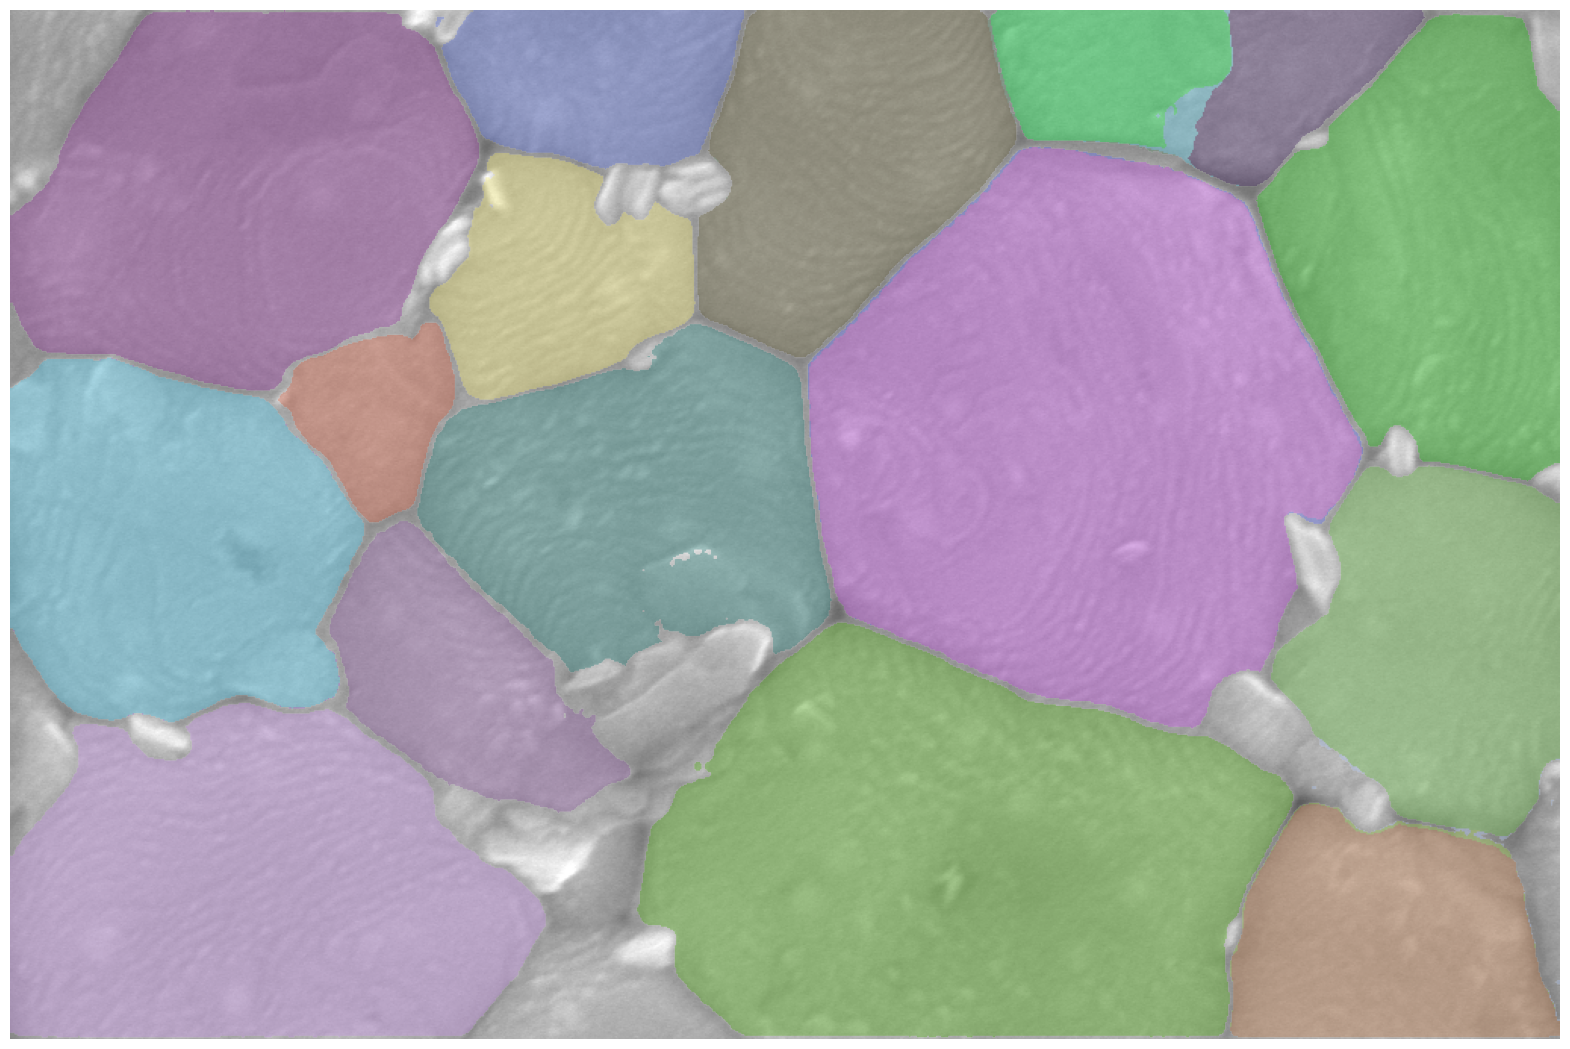

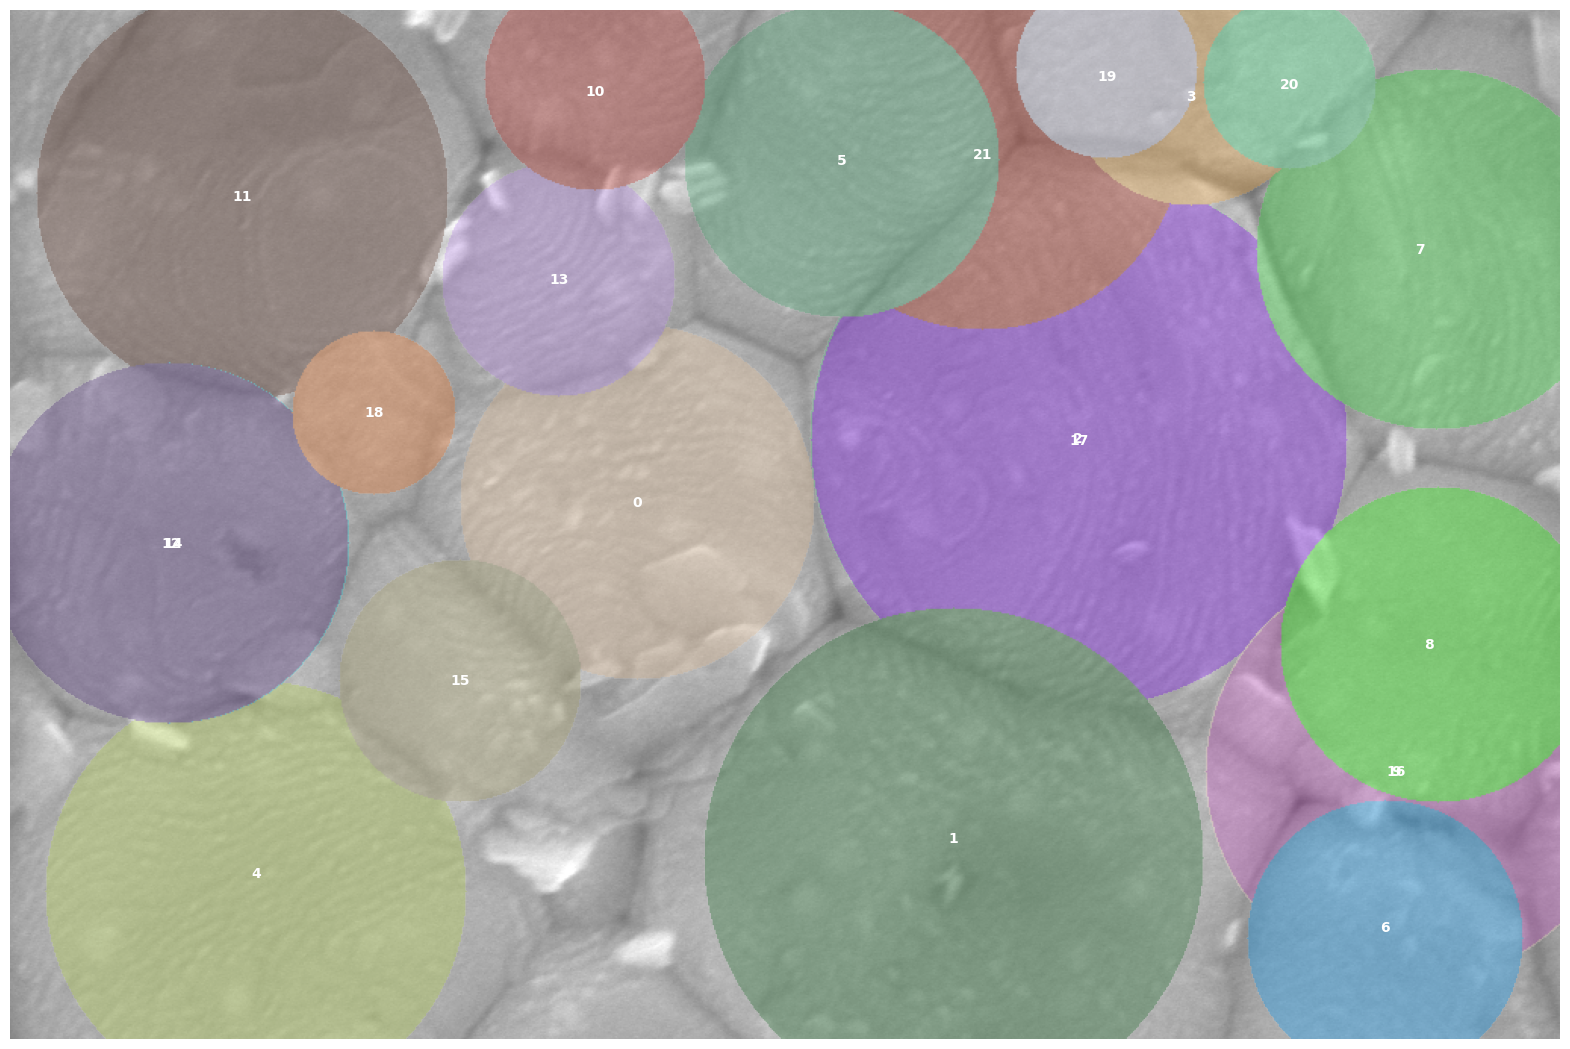

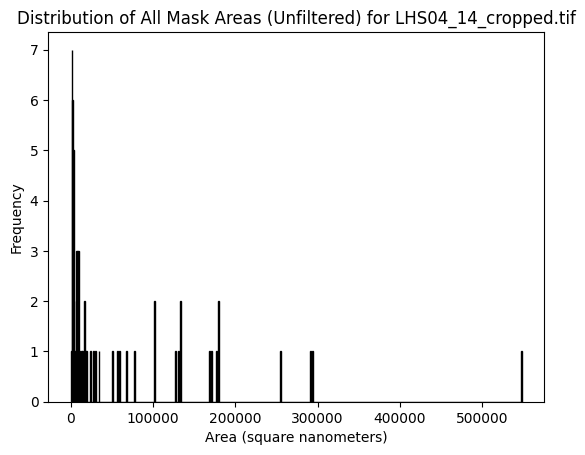

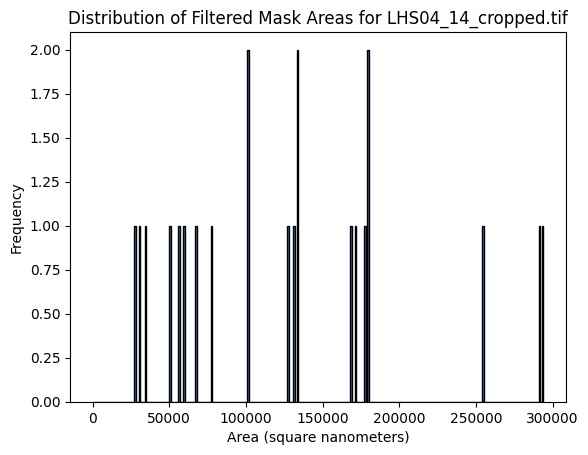

Average mask size in square nanometers for LHS04_14_cropped.tif: 129487.97
Standard deviation of mask size for LHS04_14_cropped.tif: 79624.86
Standard error of the mean mask size for LHS04_14_cropped.tif: 16976.08
Average diameter of circular masks in nanometers for LHS04_14_cropped.tif: 373.17
Standard deviation of diameters for LHS04_14_cropped.tif: 125.51
Standard error of the mean diameter for LHS04_14_cropped.tif: 26.76

--- Overall Statistics ---
Overall average mask size in square nanometers: 59198.38
Overall standard deviation of mask size: 98130.17
Overall standard error of the mean mask size: 12462.54
Overall average diameter of circular masks in nanometers: 373.17
Overall standard deviation of diameters: 125.51
Overall standard error of the mean diameter: 26.76
Processing complete.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

all_mask_areas = []
all_diameters = []

for filename in os.listdir('images'):
    if "_cropped" in filename:
        print(f"Processing {filename}...")

        # Step 1: Load and process the image
        image_path = os.path.join('images', filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Step 2: Generate masks using SAM
        mask_generator = SamAutomaticMaskGenerator(sam)
        masks = mask_generator.generate(image)

        # Step 3: Aggregate all mask areas (unfiltered) for overall statistics
        areas_unfiltered_nm2 = []
        for mask in masks:
            area_nm2 = mask['area'] * (pixels_to_micrometers ** 2) * square_micrometers_to_square_nanometers
            areas_unfiltered_nm2.append(area_nm2)
            all_mask_areas.append(area_nm2)

        # Step 4: Filter masks based on area in square nanometers
        filtered_masks = []
        for mask in masks:
            mask_area_square_micrometers = mask['area'] * (pixels_to_micrometers ** 2)
            mask_area_square_nanometers = mask_area_square_micrometers * square_micrometers_to_square_nanometers
            if lower_limit <= mask_area_square_nanometers <= upper_limit:
                filtered_masks.append(mask)

        # Aggregate mask areas for filtered masks
        areas_nm2 = []
        for mask in filtered_masks:
            area_nm2 = mask['area'] * (pixels_to_micrometers ** 2) * square_micrometers_to_square_nanometers
            areas_nm2.append(area_nm2)

        # Step 5: Create circular masks
        circular_masks = []
        diameters_nm = []
        for mask_data in filtered_masks:
            original_area = np.sum(mask_data['segmentation'])
            radius = int(np.sqrt(original_area / np.pi))
            y_coords, x_coords = np.where(mask_data['segmentation'])
            centroid = (int(np.mean(y_coords)), int(np.mean(x_coords)))
            circular_mask = create_circular_mask(image.shape[:2], centroid, radius)
            circular_masks.append({
                'segmentation': circular_mask,
                'area': np.sum(circular_mask),
            })
            diameter_nm = 2 * np.sqrt(np.sum(circular_mask) / np.pi) * pixels_to_micrometers * 1000
            diameters_nm.append(diameter_nm)
            all_diameters.append(diameter_nm)

        # Display the masks
        plt.figure(figsize=(20, 20))
        plt.imshow(image)
        show_anns(masks)
        plt.title("Original Masks")
        plt.axis('off')
        plt.show()

        # Display the filtered masks
        plt.figure(figsize=(20, 20))
        plt.imshow(image)
        show_anns(filtered_masks)
        # plt.title("Filtered Masks")
        plt.axis('off')
        plt.show()

        # Display the circular masks
        plt.figure(figsize=(20, 20))
        plt.imshow(image)
        show_anns(circular_masks)
        plt.title("Circular Masks")
        plt.axis('off')
        plt.show()

        # Plot histogram of all mask areas (unfiltered)
        bins = range(0, int(max(areas_unfiltered_nm2)) + 1000, 1000)
        plt.hist(areas_unfiltered_nm2, bins=bins, edgecolor='black')
        plt.xlabel('Area (square nanometers)')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of All Mask Areas (Unfiltered) for {filename}')
        plt.show()

        # Plot histogram of filtered mask areas
        if areas_nm2:  # Check if there are filtered masks
            bins = range(0, int(max(areas_nm2)) + 1000, 1000)
            plt.hist(areas_nm2, bins=bins, edgecolor='black')
            plt.xlabel('Area (square nanometers)')
            plt.ylabel('Frequency')
            plt.title(f'Distribution of Filtered Mask Areas for {filename}')
            plt.show()

        # Calculate statistics for the current image
        if areas_nm2:
            average_mask_size = np.mean(areas_nm2)
            std_dev_mask_size = np.std(areas_nm2, ddof=1)
            sem_mask_size = std_dev_mask_size / np.sqrt(len(areas_nm2))

            average_diameter_nm = np.mean(diameters_nm)
            std_dev_diameter_nm = np.std(diameters_nm, ddof=1)
            sem_diameter_nm = std_dev_diameter_nm / np.sqrt(len(diameters_nm))

            # Print individual image statistics
            print(f"Average mask size in square nanometers for {filename}: {average_mask_size:.2f}")
            print(f"Standard deviation of mask size for {filename}: {std_dev_mask_size:.2f}")
            print(f"Standard error of the mean mask size for {filename}: {sem_mask_size:.2f}")
            print(f"Average diameter of circular masks in nanometers for {filename}: {average_diameter_nm:.2f}")
            print(f"Standard deviation of diameters for {filename}: {std_dev_diameter_nm:.2f}")
            print(f"Standard error of the mean diameter for {filename}: {sem_diameter_nm:.2f}")

# After processing all images, calculate overall statistics
overall_average_mask_size = np.mean(all_mask_areas)
overall_std_dev_mask_size = np.std(all_mask_areas, ddof=1)
overall_sem_mask_size = overall_std_dev_mask_size / np.sqrt(len(all_mask_areas))

overall_average_diameter = np.mean(all_diameters)
overall_std_dev_diameter = np.std(all_diameters, ddof=1)
overall_sem_diameter = overall_std_dev_diameter / np.sqrt(len(all_diameters))

# Assuming all_diameters is a list or numpy array
np.savetxt('all_diameters.txt', all_diameters, delimiter='\t')

# Display overall statistics
print("\n--- Overall Statistics ---")
print(f"Overall average mask size in square nanometers: {overall_average_mask_size:.2f}")
print(f"Overall standard deviation of mask size: {overall_std_dev_mask_size:.2f}")
print(f"Overall standard error of the mean mask size: {overall_sem_mask_size:.2f}")

print(f"Overall average diameter of circular masks in nanometers: {overall_average_diameter:.2f}")
print(f"Overall standard deviation of diameters: {overall_std_dev_diameter:.2f}")
print(f"Overall standard error of the mean diameter: {overall_sem_diameter:.2f}")

print("Processing complete.")